# Reinforce with recnn

The following code contains an implementation of the REINFORCE algorithm, **without Off Policy Correction, LSTM state encoder, and Noise Contrastive Estimation**. Look for these in other notebooks.

Also, I am not google staff, and unlike the paper authors, I cannot have online feedback concerning the recommendations.

**I use actor-critic for reward assigning.** In a real-world scenario that would be done through interactive user feedback, but here I use a neural network (critic) that aims to emulate it.

note: due to implementation details, this algorithm currently doesn't support testing

In [5]:
import torch
import torch.nn as nn
from torch.utils.tensorboard import SummaryWriter

import numpy as np
import pandas as pd
from tqdm.auto import tqdm
from time import gmtime, strftime

from IPython.display import clear_output
import matplotlib.pyplot as plt
%matplotlib inline


# == recnn ==
import sys
sys.path.append("../../")
import recnn

cuda = torch.device('cuda')

# ---
frame_size = 10
batch_size = 10
n_epochs   = 100
plot_every = 30
num_items    = 5000 # n items to recommend. Can be adjusted for your vram 
# --- 

tqdm.pandas()


from jupyterthemes import jtplot
jtplot.style(theme='grade3')

In [6]:
def embed_batch(batch, item_embeddings_tensor, *args, **kwargs):
    return recnn.data.batch_contstate_discaction(batch, item_embeddings_tensor,
                                                 frame_size=frame_size, num_items=num_items)

    
def prepare_dataset(args_mut, kwargs):
    kwargs.set('reduce_items_to', num_items) # set kwargs for your functions here!
    pipeline = [recnn.data.truncate_dataset, recnn.data.prepare_dataset]
    recnn.data.build_data_pipeline(pipeline, kwargs, args_mut)
    


# embeddgings: https://drive.google.com/open?id=1EQ_zXBR3DKpmJR3jBgLvt-xoOvArGMsL
dirs = recnn.data.env.DataPath(
    base="../../data/",
    embeddings="embeddings/ml20_pca128.pkl",
    ratings="ml-20m/ratings.csv",
    # IMPORTANT! I am using a different name for cache
    # If you change your pipeline, change the name as well!
    # Different pipelines must have different names!
    cache="cache/frame_env_truncated.pkl", 
    use_cache=True
)

env = recnn.data.env.FrameEnv(
    dirs, frame_size,
    batch_size,
    embed_batch=embed_batch,
    prepare_dataset=prepare_dataset,
    num_workers=0
)

0%|          | 0/18946308 [00:00<?, ?it/s]4999
action space is reduced to 26744 - 21744 = 5000
4999
None
100%|██████████| 18946308/18946308 [00:14<00:00, 1298942.64it/s]
max movie_thingy 4999
100%|██████████| 138493/138493 [00:06<00:00, 19850.04it/s]


In [7]:
value_net  = recnn.nn.Critic(1290, num_items, 2048, 54e-2).to(cuda)
policy_net = recnn.nn.DiscreteActor(1290, num_items, 2048).to(cuda)

reinforce = recnn.nn.Reinforce(policy_net, value_net)
reinforce = reinforce.to(cuda)

reinforce.writer = SummaryWriter(log_dir='../../runs/Reinforce{}/'.format(strftime("%H_%M", gmtime())))
plotter = recnn.utils.Plotter(reinforce.loss_layout, [['value', 'policy']],)

step 990


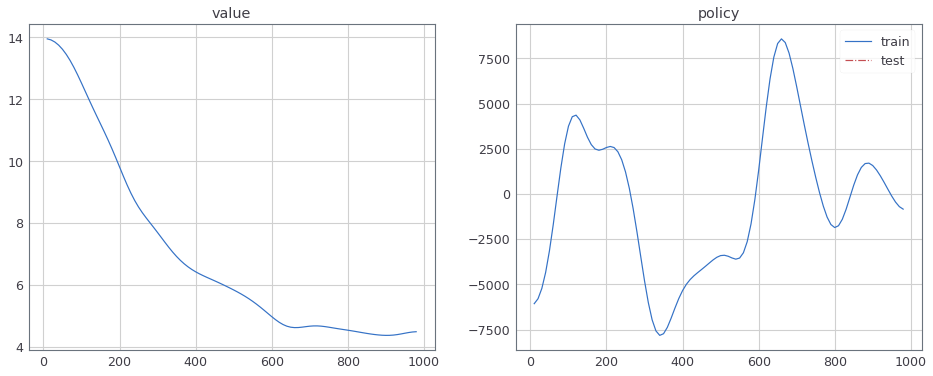

8%|▊         | 1000/13156 [01:29<18:05, 11.20it/s]


AssertionError: 

In [8]:
for epoch in range(n_epochs):
    for batch in tqdm(env.train_dataloader):
        loss = reinforce.update(batch)
        reinforce.step()
        if loss:
            plotter.log_losses(loss)
        if reinforce._step % plot_every == 0:
            clear_output(True)
            print('step', reinforce._step)
            plotter.plot_loss()
        if reinforce._step > 1000:
            pass
            assert False